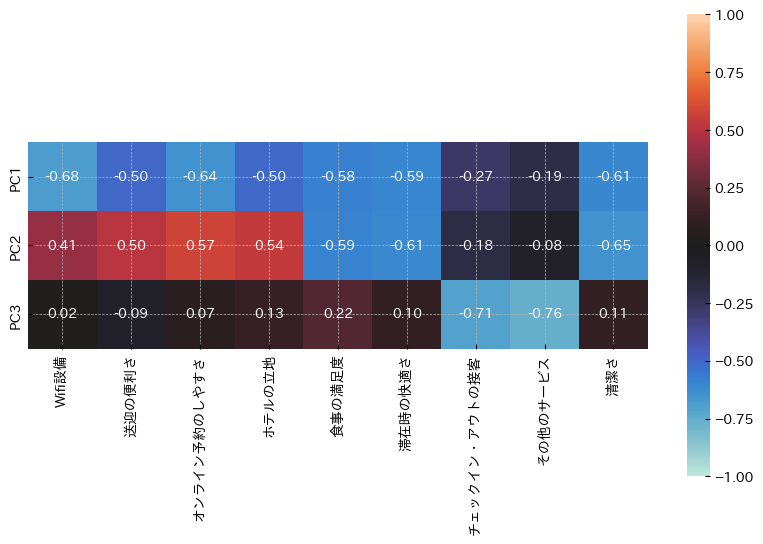

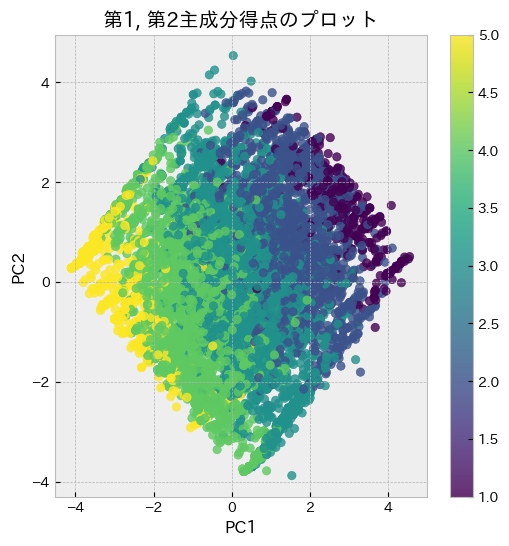

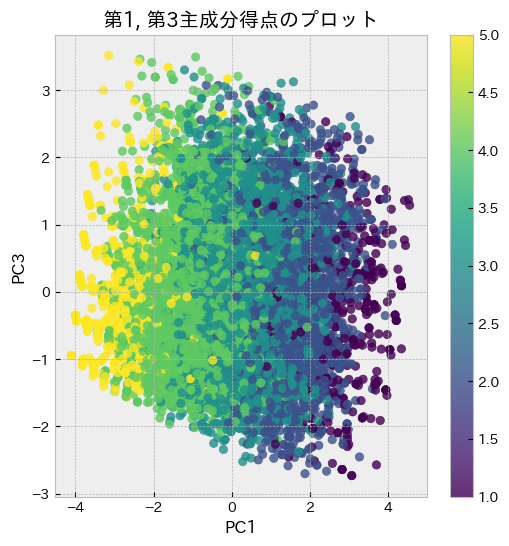

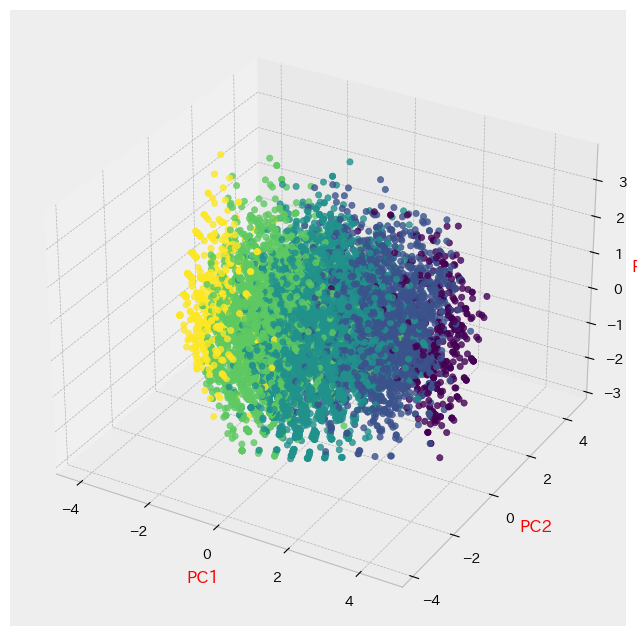

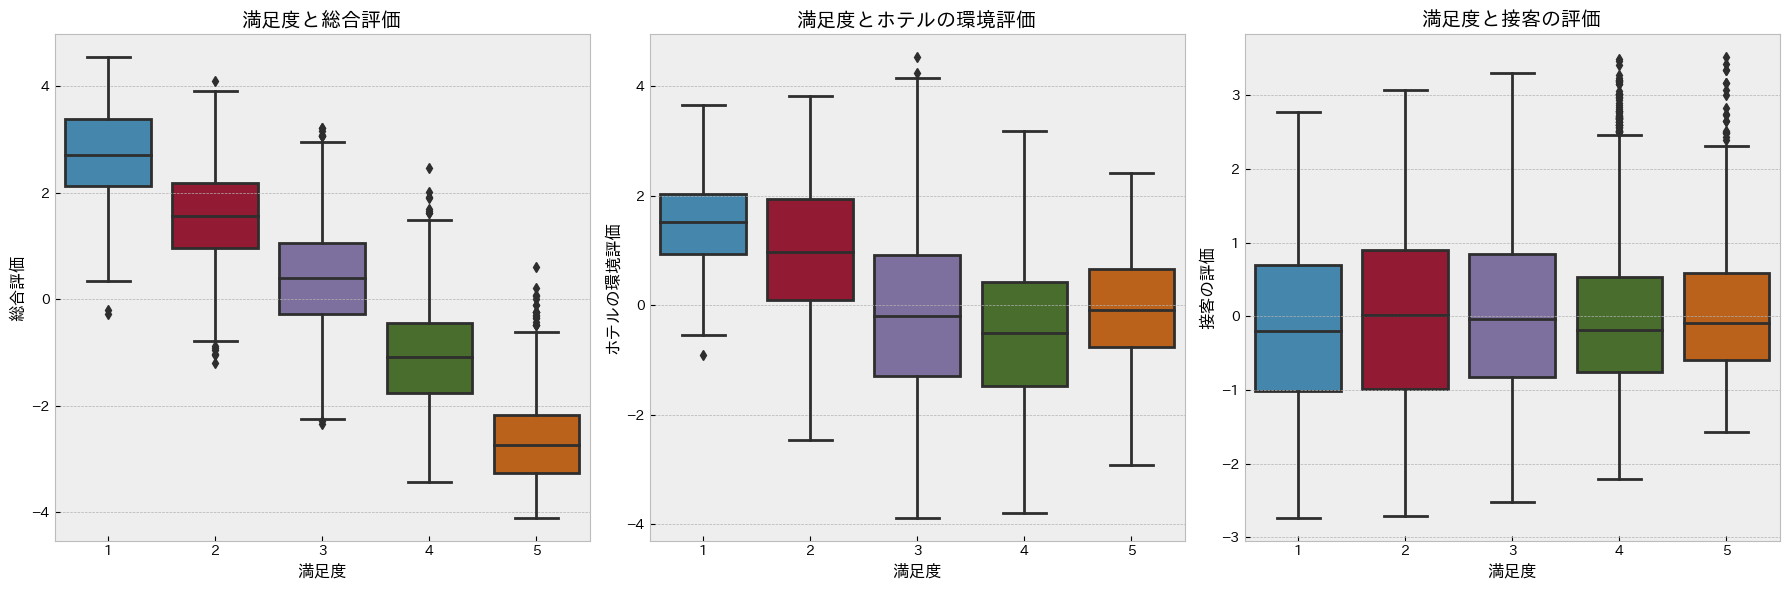

In [16]:
"""
データ分析　演習問題３

目的：主成分分析を用いて、ホテルの満足度に影響を与える要因を分析する
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from scipy import stats
import warnings

import statsmodels.api as sm

warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh') # matplotlib のスタイルの設定

plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv('../../data/dummy_data/hotel_reviews.csv')

# 数値型のデータのみを抽出 & 満足度を除く
df_numeric = df.select_dtypes(include='number').drop(['満足度'], axis=1)


# 相関を確認
# sns.heatmap(df_numeric.corr(), annot=True, square=True, vmax=1, vmin=-1, center=0, fmt='.2f')

# 年齢を省く(相関が低いもの省く)
data = df_numeric.drop(['年齢'], axis=1)

# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# DataFrameに変換
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# 主成分分析

# モデル作成
from sklearn.decomposition import PCA
pca = PCA(random_state=0)

# 分析実行
# NOTE: featureは主成分得点
feature = pca.fit_transform(data_scaled)

# 寄与率
varacne_ratio = pca.explained_variance_ratio_

pd.DataFrame(varacne_ratio, index=[f'PC{x+1}' for x in range(len(varacne_ratio))], columns=['寄与率'])

# 固有ベクトル
eigen_vector = pca.components_

# 固有値の平方根
sqrt_eigen_value = np.c_[np.sqrt(pca.explained_variance_)]

# 主成分負荷量
factor_loadings = eigen_vector * sqrt_eigen_value

# DataFrameに
df_factor_loadings = pd.DataFrame(factor_loadings, index=[f'PC{x+1}' for x in range(len(factor_loadings))], columns=data.columns)

# ヒートマップ
# NOTE: この場合の主成分の解釈の例
#       PC１：すべての項目に対する評価の成分
#       PC２：設備とサービスを分ける（ホテルの環境に対する）成分
#       PC３：接客に対する評価の成分
sns.heatmap(df_factor_loadings.head(3), annot=True, square=True, vmax=1, vmin=-1, center=0, fmt='.2f')

# 主成分の可視化

def feature_plot(x=1, y=2):
    """主成分得点をプロットする関数"""
    plt.figure(figsize=(6, 6))
    plt.title(f'第{x}, 第{y}主成分得点のプロット')
    plt.scatter(feature[:, x-1], feature[:, y-1], alpha=0.8, c=list(df.iloc[:, -1]))
    plt.xlabel(f'PC{x}')
    plt.ylabel(f'PC{y}')
    plt.colorbar()
    plt.show()
    
feature_plot(1, 2)
feature_plot(1, 3)

# 3つ成分を一気に可視化（３Dで可視化）
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC1', c='r')
ax.set_ylabel('PC2', c='r')
ax.set_zlabel('PC3', c='r')
ax.scatter(feature[:, 0], feature[:, 1], feature[:, 2], alpha=0.8, c=list(df.iloc[:, -1]))
plt.show()



# 各主成分をDataFrameに
_df_feature = pd.DataFrame(feature[:, :3], columns=['総合評価', 'ホテルの環境評価', '接客の評価'])

# 元のデータに結合
df_new = pd.concat([df, _df_feature], axis=1)

# 箱ひげ図で可視化
plt.rcParams['figure.figsize'] = 18, 6
plt.subplot(1, 3, 1)
plt.title('満足度と総合評価')
sns.boxplot(x='満足度', y='総合評価', data=df_new)
plt.subplot(1, 3, 2)
plt.title('満足度とホテルの環境評価')
sns.boxplot(x='満足度', y='ホテルの環境評価', data=df_new)
plt.subplot(1, 3, 3)
plt.title('満足度と接客の評価')
sns.boxplot(x='満足度', y='接客の評価', data=df_new)
plt.tight_layout()
